# Timeseries to Predict the Number of Air Passangers

__[Data Set: Air Passengers Kaggle](https://www.kaggle.com/rakannimer/air-passengers)__

## Preparing Resources

### Importing Libraries

In [107]:
import pandas as pd
import numpy as np
import scipy.stats as st

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

### Reading Dataset

In [22]:
df_pass = pd.read_csv('data/AirPassengers.csv')

In [23]:
df_pass.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


## Preparing DataSet

### Adjusting Date

In [24]:
df_pass['Month'] = pd.to_datetime(df_pass['Month'])

In [25]:
df_pass.head()

,Month,#Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [26]:
df_pass = df_pass.set_index('Month')

In [27]:
df_pass.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


### Plotting Data

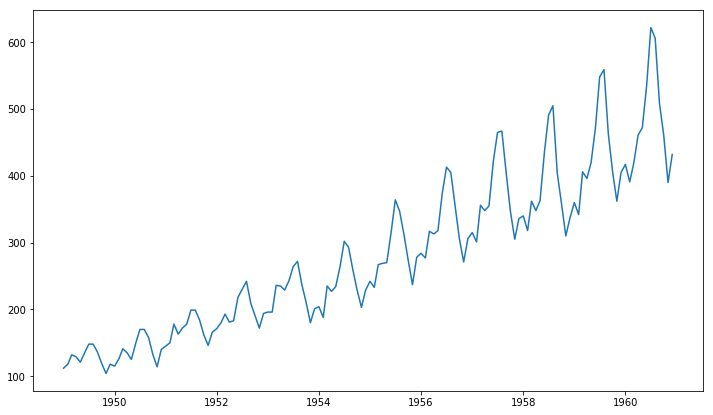

In [44]:
plt.figure(figsize=(12,7))
plt.plot(df_pass)
plt.show()

### Stationarity Test

In [41]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(12,7))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    
    plt.show(block=False)

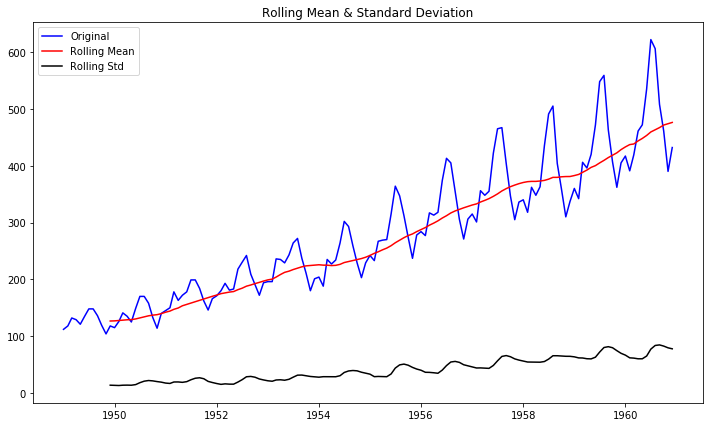

In [42]:
test_stationarity(df_pass)

Using the stationarity test we can note the tendency on data (red)! Analyzing the standard deviation is possible to note that there is variation on the data as well (black). To sum-up, analyzing the chart we can conclude that this series **is not** stationary. We need to work on that

## Transforming Serie on Stationary

In [45]:
df_transf = df_pass.copy(deep=True)

In [46]:
df_transf.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


### Using log transformation to reduce the tendency

In [47]:
df_transf['#Passengers'] = np.log(df_transf['#Passengers'])

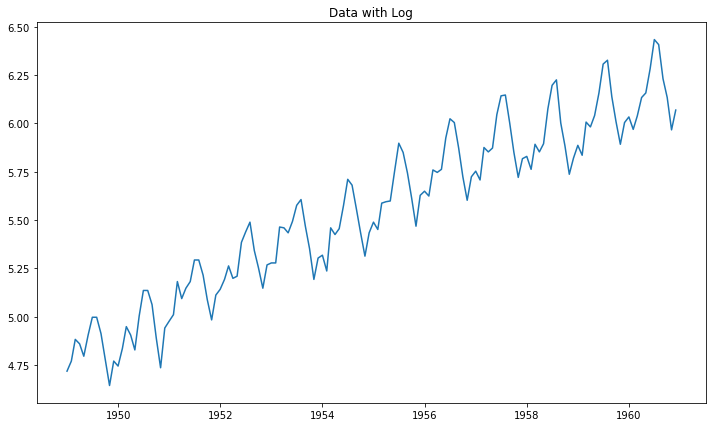

In [50]:
plt.figure(figsize=(12,7))
plt.title("Data with Log")
plt.plot(df_transf)
plt.show()

Comparisson between the charts

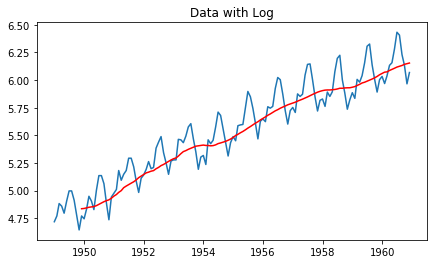

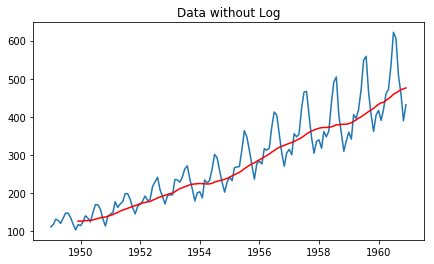

In [62]:
plt.figure(figsize=(7,4))
plt.title("Data with Log")
plt.plot(df_transf)
moving_avg = df_transf.rolling(12).mean()
plt.plot(moving_avg, color='red')

plt.figure(figsize=(7, 4))
plt.title("Data without Log")
plt.plot(df_pass)
moving_avg = df_pass.rolling(12).mean()
plt.plot(moving_avg, color='red')
plt.show()


Much Better!

## Decomposing the series

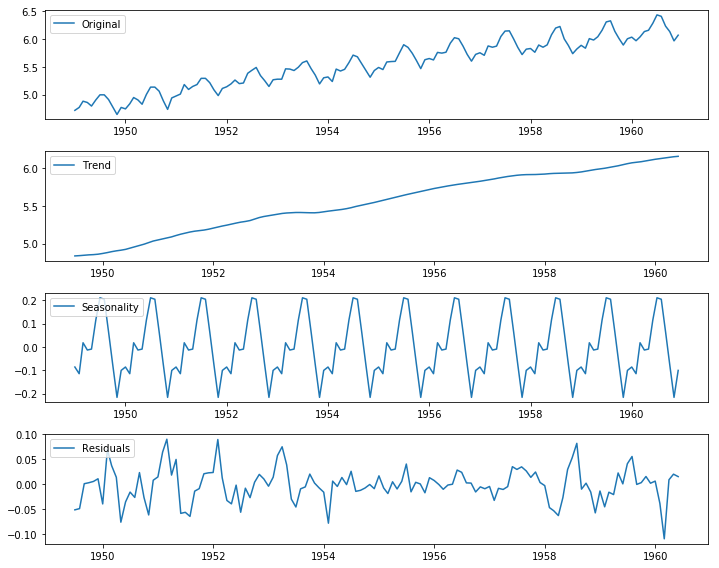

In [81]:
decomposition = seasonal_decompose(df_transf)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(10, 8))
plt.subplot(411)
plt.plot(df_transf, label='Original')
plt.legend(loc=2)
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc=2)
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc=2)
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc=2)
plt.tight_layout()

## Forecasting - ARIMA

### ACF and PACF plots

In [104]:
df_transf_diff = df_transf - df_transf.shift()
df_transf_diff.dropna(inplace=True)
lag_acf = acf(df_transf_diff, nlags=20)
lag_pacf = pacf(df_transf_diff, nlags=20, method='ols')

### ACF - Auto Correlation Function Plot

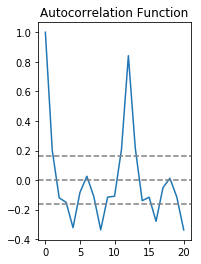

In [105]:
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_transf_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_transf_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.show()

### PACF - Partial Autocorrelation Function Plot

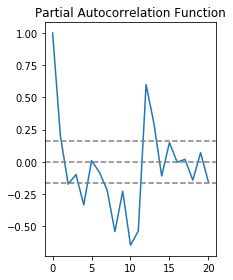

In [106]:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_transf_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_transf_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

If we use the confidence interval the best values for ACF and PCF are:
- ACF (q): When the line cross the upper interval for the first time the value is close to **2**
- PACF (p): When the line cross the upper interval for the first time the value is close to **2**
- Itegration order (d) - We will use the same value **2**

### Best Parameters with "Grid Search" and AIC

In [108]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [112]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_transf,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:898.7367486840988
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:687.3749017314515
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:-150.62577301420401
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:-179.24122974055112
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:-344.53629719317615
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:-342.6089190943811
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:-225.9086914493485
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:-301.46045597141796
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:704.0097395065309
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:509.22247300887466
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:-254.34077322301806
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:-248.42231756143295
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:-396.27944661884584
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:-395.71372433442883
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:-271.43123351319946
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:-339.49928501796484
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:-230.04132958357417
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:-29

The interation with bast parameters and lower AIC value was: **ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:-477.61938658445985**

### Training Model with the best parameters

In [113]:
mod = sm.tsa.statespace.SARIMAX(df_transf,
                                order=(1, 0, 1),
                                seasonal_order=(1, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9419      0.039     24.102      0.000       0.865       1.019
ma.L1         -0.3803      0.093     -4.092      0.000      -0.562      -0.198
ar.S.L12       1.0200      0.003    302.487      0.000       1.013       1.027
ma.S.L12      -0.5747      0.107     -5.387      0.000      -0.784      -0.366
sigma2         0.0013      0.000      9.240      0.000       0.001       0.002


### Analysing the Residual (White Noise)

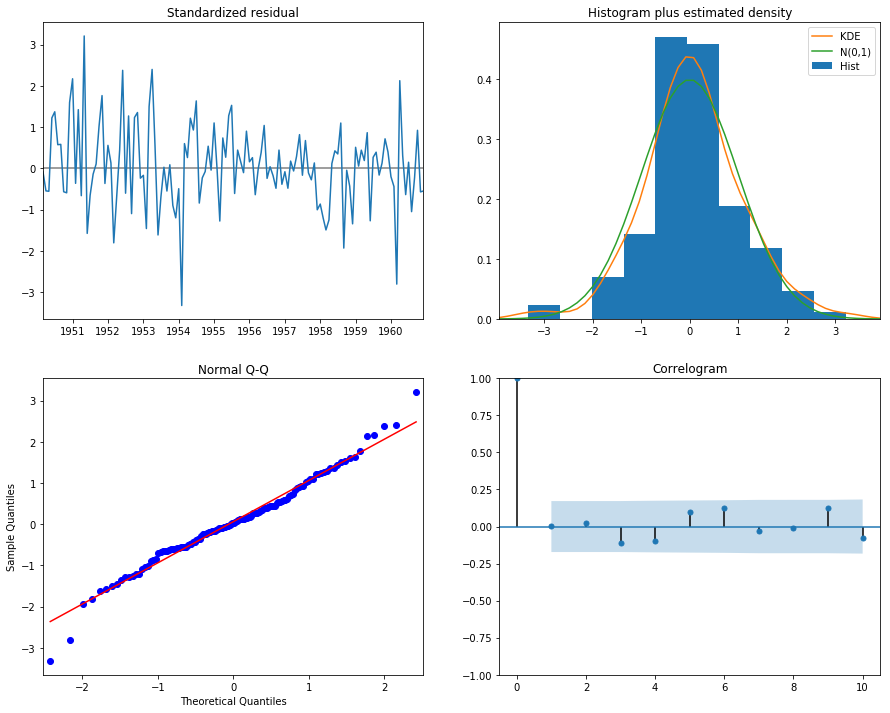

In [114]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

## Validating the Forecast

In [141]:
pred = results.get_prediction(start=pd.to_datetime('1955-01-01'), dynamic=False)
pred_ci = pred.conf_int()

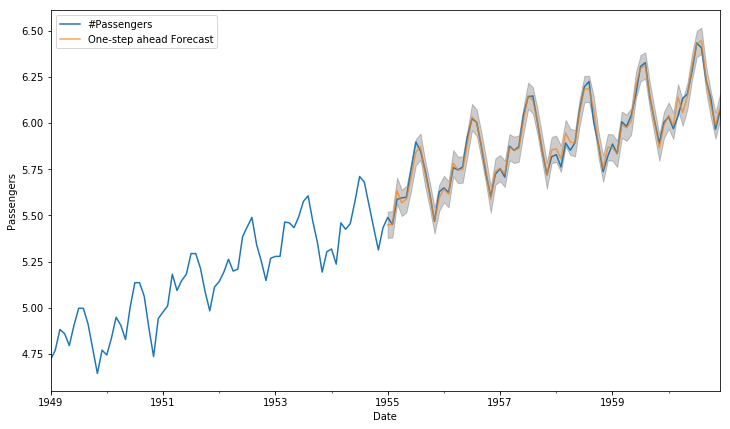

In [145]:
ax = df_transf['1949':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, 
                         label='One-step ahead Forecast', 
                         alpha=.7, 
                         figsize=(12,7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], 
                color='k', 
                alpha=.2)


ax.set_xlabel('Date')
ax.set_ylabel('Passengers')
plt.legend()

plt.show()

### Forecast MSE

In [156]:
y_truth = df_transf['1955-01-01':]
y_forecasted = pred.predicted_mean
y_truth['#Passengers'] = y_truth['#Passengers'].astype(float)
y_truth['Forcast'] = y_forecasted.astype(float)

mse = ((y_truth['#Passengers'] - y_truth['Forcast']) ** 2).mean()
print('The Mean Squared Error of Forecast is {}'.format(round(mse, 4)))

The Mean Squared Error of our forecasts is 0.0009


## Serie Forecast

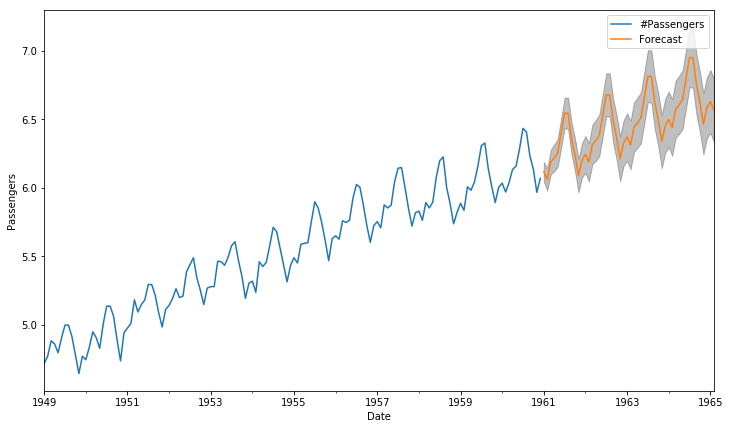

In [161]:
pred_uc = results.get_forecast(steps=50)
pred_ci = pred_uc.conf_int()
ax = df_transf.plot(label='observed', figsize=(12, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Passengers')
plt.legend()
plt.show()